# Email Prediction Service Training with XLNet

This Jupyter Notebook focuses on training an XLNet model specifically tailored for classifying email content. The guide outlines essential steps including model and tokenizer initialization, data preprocessing, setting up the training loop, and evaluating model performance. The training process is optimized for understanding and efficiency, ensuring a solid foundation for further development, such as integrating the model into prediction services or other applications in the future.


## Setup

Before starting, ensure all necessary libraries are installed.


In [2]:
!pip install transformers torch pandas matplotlib seaborn tqdm

## Step 1: Import Required Libraries

Import all necessary libraries for the training process.



In [3]:
import pandas as pd
import torch
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm  # Use auto to ensure compatibility in Jupyter
import matplotlib.pyplot as plt
import seaborn as sns


## Step 2: Prepare the Dataset

Load and preprocess the dataset, including converting categorical labels into numeric ones.

In [4]:
# Load the dataset
df = pd.read_csv('./processed_data/enhanced.csv')
print("Dataset loaded successfully.")

# Map 'Actual Service' to numeric labels
unique_services = df['Actual Service'].unique()
service_to_label = {service: i for i, service in enumerate(unique_services)}
df['Label'] = df['Actual Service'].apply(lambda x: service_to_label[x])

print("Service to Label Mapping:", service_to_label)
print(df.head())


Dataset loaded successfully.
Service to Label Mapping: {'UWE Devices and Hardware Support': 0, 'Software Delivery': 1, 'IT Service Desk and Customer Support': 2, 'Lecture and AV Technologies': 3, 'Virtual Environments': 4, 'Student Application Experience': 5, 'Digital Learning': 6, 'Facilities - Business Systems': 7, 'Password and Identity Management': 8, 'Staff Printing': 9, 'Facilities - Operations': 10, 'Collaboration Tools': 11, 'Remote Connectivity': 12, 'Student Records/Administration': 13, 'Web and intranet systems': 14, 'Student Printing': 15, 'UWE Device Management': 16, 'PC, Mobile Device, and Software Delivery': 17, 'Email and Calendaring': 18, 'WiFi Networks': 19, 'Web Services': 20, 'Telephony and Video Conferencing': 21, 'Service Desk and Customer Support': 22, 'Software Usage and Availability': 23, 'Authentication and Identity Management': 24, 'Desktop Software Deployment': 25, 'Virtual Learning Environments': 26, 'Student Journey Systems': 27, 'Networking Service': 28, 

## Step 3: Define the Dataset Class
Create a custom dataset class to handle tokenization and data preparation for training.

In [5]:
class EmailDataset(Dataset):
    def __init__(self, tokenizer, df, max_len=512):
        self.tokenizer = tokenizer
        self.texts = df['Ticket Description'].tolist()
        self.labels = df['Label'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("EmailDataset class defined.")


EmailDataset class defined.


## Step 4: Initialize Model and Tokenizer
Load the XLNet model and tokenizer with the appropriate number of labels.

In [6]:
MODEL_NAME = 'xlnet-base-cased'
NUM_LABELS = len(unique_services)

def load_model():
    tokenizer = XLNetTokenizer.from_pretrained(MODEL_NAME)
    model = XLNetForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    return model, tokenizer

model, tokenizer = load_model()
print("Model and tokenizer loaded.")


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded.


## Step 5: Prepare the Data Loader
Initialize the dataset and data loader for training.

In [10]:
dataset = EmailDataset(tokenizer, df)
dataloader = DataLoader(dataset, batch_size=4) #adjust batch size, more = more memory
print("Dataloader is ready.")


Dataloader is ready.


## Step 6: Setup Training
Configure the device, optimizer, and move the model to the appropriate device.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

print(f"Using device: {device}")


Using device: cpu


## Step 7: Train the Model
Implement the training loop, including monitoring for loss and progress.

### Gradient Accumulation
Gradient accumulation is something we can use to effectively increase the batch size without increasing the memory requirements. It splits the batch into smaller mini-batches and accumulates the gradients over these mini-batches before performing a single optimization step.

In [12]:
EPOCHS = 3
accumulation_steps = 2  # Accumulate gradients over 2 forward passes

loss_values = []  # Ensure this list is defined outside the loop

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
    optimizer.zero_grad()  # Move zero_grad() outside the batch loop
    for step, batch in enumerate(progress_bar):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss / accumulation_steps  # Scale loss
        total_loss += loss.item()

        loss.backward()
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        progress_bar.set_postfix({'loss': f'{(total_loss * accumulation_steps):.2f}'})

    # Calculate and store the average loss for the epoch
    avg_epoch_loss = total_loss / len(dataloader)
    loss_values.append(avg_epoch_loss)  # Append the average loss to the list

    print(f"Average Loss for Epoch {epoch + 1}: {avg_epoch_loss:.2f}")

Epoch 1:   0%|          | 0/2342 [00:00<?, ?it/s]

Average Loss for Epoch 1: 0.75


Epoch 2:   0%|          | 0/2342 [00:00<?, ?it/s]

Average Loss for Epoch 2: 0.37


Epoch 3:   0%|          | 0/2342 [00:00<?, ?it/s]

Average Loss for Epoch 3: 0.29


## Step 8: Saving the Trained Model and Tokenizer

After the model has been trained, it can be saved using PyTorch's save function. It's also a good practice to save the tokenizer alongside the model, especially when dealing with NLP tasks, to ensure consistency during inference.

In [14]:
# Define a path for saving the model and tokenizer
model_path = './model/xlnet_email_classifier_model'
tokenizer_path = './model/xlnet_email_classifier_tokenizer'

# Save the model
model.save_pretrained(model_path)
print(f"Model saved to {model_path}")

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_path)
print(f"Tokenizer saved to {tokenizer_path}")


Model saved to ./model/xlnet_email_classifier_model
Tokenizer saved to ./model/xlnet_email_classifier_tokenizer


## Step 9: Plotting the Training loss

At the end of each epoch, the average loss is calculated by dividing the total loss (accumulated over all batches) by the number of batches (len(dataloader)). This average loss is then appended to the loss_values list. After the training loop completes, loss_values will correctly contain the average loss for each epoch, making it ready for use in plotting and other analysis.

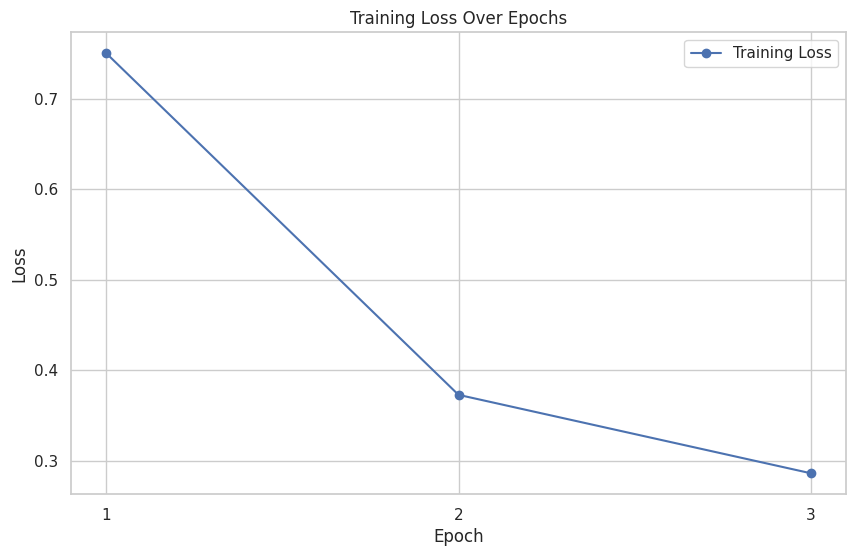

In [15]:
# Set the Seaborn theme if you like
sns.set_theme(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(range(1, EPOCHS+1), loss_values, 'o-', label='Training Loss')  # Plot the training loss

# Add titles and labels
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, EPOCHS + 1))  # Ensure x-axis labels match epochs
plt.legend()

# Show the plot
plt.show()
